# 3D Single-shot Object Detection Method
---------------------------------------
#### Realizado por: Juan C. Peña y Eberto Benjumea

## Resumen
-----------
Este trabajo se enfoca en el procesamiento y detección de objetos en imágenes 3D mediante técnicas de *Self-supervised Deep Learning*. El proceso consta de las siguientes etapas:

1. **Preprocesamiento del Recorte**: Se realiza el preprocesamiento de un recorte de la imagen, incluyendo recorte, normalización y visualización de histogramas.

2. **Generación de Recortes Transformados en 3D**: Se generan recortes transformados en 3D a partir del recorte original y rangos de transformaciones.

3. **Aplicación de Transformaciones 2D**: Se aplican transformaciones 2D a los recortes transformados para generar el conjunto de entrenamiento.

4. **Entrenamiento del Modelo**: Se entrena un modelo utilizando el conjunto de entrenamiento y se visualiza el progreso del entrenamiento.

5. **Detección Multi-escala de Objetos**: Se realiza la detección de objetos en imágenes de prueba a diferentes escalas y se visualizan las detecciones.

6. **Supresión del No Máximo**: Se ajustan y visualizan los bounding boxes finales utilizando la supresión del no máximo.



# A) Instalación e importación de módulos
-------



### Librería deeptrack

In [1]:
#@title
%%capture
!pip install deeptrack

### Otras librerías y funciones utilizadas

In [2]:
#@title
%%capture
import os
import cv2
import scipy
import random
import numpy as np
import deeptrack as dt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial.transform import Rotation as R
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

### Conexión con Google Drive

In [3]:
#@title
%%capture
from google.colab import drive
drive.mount('/content/drive')

-----------

# B) Carga de la información
-------
En esta etapa, se realiza la carga de los datos necesarios para el procesamiento. Los datos se cargan desde un archivo utilizando `scipy.io.loadmat()` y se obtienen los arrays correspondientes a las coordenadas X, Y y Z.

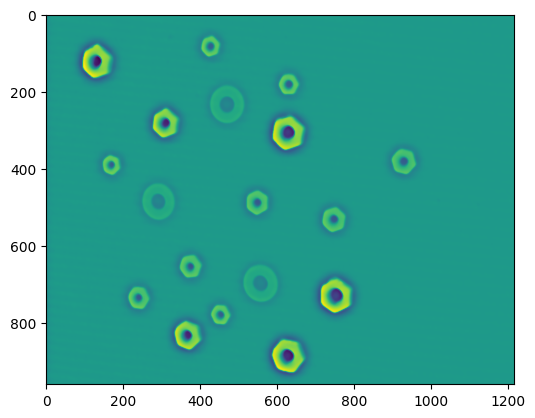

In [4]:
# Cargar los datos
train_data = scipy.io.loadmat('/content/drive/MyDrive/Investigacion/Data/MATLAB/3D/reconstruction12.mat')
Spx, Spy, Spz = train_data['XcM'], train_data['YcM'], train_data['Spz']
plt.imshow(Spz)

# C) Metodología para la detección de objetos 3D
-----------

## 1. Preprocesamiento del recorte
----

En esta sección, se realiza el preprocesamiento de un recorte de la imagen. El recorte se obtiene a partir de las coordenadas X, Y y Z previamente cargadas. El preprocesamiento consta de los siguientes pasos:

1. Se realiza un recorte del recorte original con base en las coordenadas y el tamaño especificados.
2. Se aplica una normalización al recorte utilizando los cuantiles 0.01 y 0.99 para escalonar los valores.
3. Se muestra la imagen del recorte original junto con los histogramas del recorte original y del recorte preprocesado.

La función `preprocess_crop` se encarga de realizar todo este proceso, tomando como entrada el recorte original y los parámetros de recorte, y devolviendo el recorte preprocesado junto con los histogramas del recorte original y del recorte preprocesado.


-------
### Normalización de imágenes

In [5]:
#@title
def normalize_images(data):
    if isinstance(data, np.ndarray):
        data = [data]

    normalized_images = []
    for image in data:
        normalized_image = (image - np.quantile(image, 0.01)) / (np.quantile(image, 0.99) - np.quantile(image, 0.01))
        normalized_images.append(normalized_image)

    if len(normalized_images) == 1:
        return normalized_images[0]
    else:
        return normalized_images

### Visualizacion de histogramas

In [6]:
#@title
def visualize_histograms(original_image, transformed_image):
    fig, ax = plt.subplots(2, 2, figsize=(10, 5))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title("Original Image")

    ax[0, 1].hist(original_image.ravel(), bins=256, color='blue', alpha=0.7)
    ax[0, 1].set_title("Original Image Histogram")

    ax[1, 0].imshow(transformed_image)
    ax[1, 0].set_title("Preprocessed Crop")

    ax[1, 1].hist(transformed_image.ravel(), bins=256, color='red', alpha=0.7)
    ax[1, 1].set_title("Preprocessed Image Histogram")

    plt.tight_layout()
    plt.show()

### Preprocesamiento del recorte

In [7]:
#@title
def preprocess_crop(crop, x, y, crop_size, plot=True):
    # Recorte del crop original
    crop = crop[y: y + crop_size, x: x + crop_size]
    # Copia de los datos originales para visualización posterior
    previous_crop = np.copy(crop)
    # Preprocesamiento del crop
    crop = normalize_images(crop)

    # Visualización
    if plot:
        visualize_histograms(previous_crop, crop)

    return crop

--------

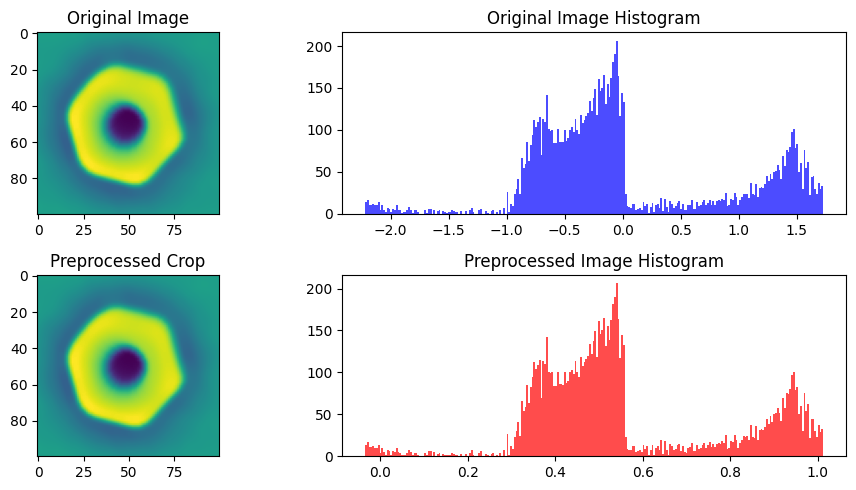

In [8]:
# Visualización del recorte original y sus histogramas
x, y, crop_size = (880, 332, 100)
preprocessed_crop = preprocess_crop(Spz, x, y, crop_size, plot=True)

## 2. Generación de Recortes Transformados en 3D
----

En esta etapa, se generan recortes transformados en 3D a partir de un recorte original y parámetros de transformación aleatorios. Los pasos principales de esta etapa son:

1. **Generación de Transformaciones Aleatorias**: Se generan parámetros de transformación aleatorios dentro de los rangos especificados, incluyendo ángulos de rotación y traslaciones en los ejes X, Y y Z. Luego, estas transformaciones son aplicadas en la imagen original.

2. **Generación y Normalización de los Recortes Transformados**: Se generan los recortes transformados y se normalizan nuevamente los datos para garantizar la consistencia en la distribución de los datos transformados.

La función `generate_transformed_crops` se encarga de todo este proceso. Toma como entrada las coordenadas espaciales, el recorte original, los rangos de transformación, la cantidad de imágenes a generar y las coordenadas de recorte. Como resultado, devuelve una lista de los recortes transformados.


------
### Generación de recortes transformados

In [9]:
#@title
def generate_transformed_crops(Sp_coordinates, crop, transformation_ranges, num_images, crop_coords):
    # Extraer las coordenadas
    Spx, Spy, Spz = Sp_coordinates['Spx'], Sp_coordinates['Spy'], Sp_coordinates['Spz']

    # Extraer las coordenadas de recorte
    x, y, crop_size = crop_coords['x'], crop_coords['y'], crop_coords['crop_size']

    # Crear una matriz 4D para las coordenadas X, Y, Z y una matriz de unos del mismo tamaño
    coordinates = np.stack([Spx, Spy, Spz, np.ones_like(Spz)])

    # Crear una lista para almacenar los crops transformados
    transformed_crops = []

    # Agregar el crop original a la lista de crops transformados
    original_crop = crop
    transformed_crops.append(original_crop)

    # Iterar sobre la cantidad de imágenes a generar (restando 1 para el recorte original)
    for _ in range(num_images - 1):
        # Generar las transformaciones aleatorias dentro de los rangos especificados
        ax = np.random.uniform(*transformation_ranges['ax'])
        ay = np.random.uniform(*transformation_ranges['ay'])
        az = np.random.uniform(*transformation_ranges['az'])
        tx = np.random.uniform(*transformation_ranges['tx'])
        ty = np.random.uniform(*transformation_ranges['ty'])
        tz = np.random.uniform(*transformation_ranges['tz'])

        # Crear la matriz de rotación utilizando scipy
        r = R.from_euler('xyz', [ax, ay, az], degrees=True)
        Rrec = r.as_matrix()

        # Crear la matriz de transformación
        Mext_rec = np.eye(4)
        Mext_rec[:3, :3] = Rrec

        # Transformar los puntos utilizando la matriz de transformación
        transformed_coordinates = Mext_rec @ coordinates.reshape(4, -1)

        # Remodelar los puntos transformados de vuelta a la forma original
        transformed_coordinates = transformed_coordinates.reshape(4, Spz.shape[0], Spz.shape[1])

        # Crear la nueva imagen 2.5D con los valores de Z transformados
        new_image_2_5D = transformed_coordinates[2, :, :]

        # Realizar la traslación en X e Y en la imagen 2.5D
        translated_image_2_5D = np.roll(new_image_2_5D, (int(tx), int(ty)), axis=(1, 0))

        # Realizar la rotación en Z y la traslación en Z en la imagen 2.5D
        rows, cols = translated_image_2_5D.shape
        M = cv2.getRotationMatrix2D((cols/2, rows/2), az, 1)
        dst = cv2.warpAffine(translated_image_2_5D, M, (cols, rows))
        transformed_image = dst + tz

        # Obtener el crop de la imagen transformada
        transformed_crop = transformed_image[y : y+crop_size, x : x+crop_size]

        # Agregar el crop transformado a la lista de crops transformados
        transformed_crops.append(transformed_crop)

    return transformed_crops

### Gráfica de recortes transformados

In [10]:
#@title
def plot_transformed_crops(transformed_crops, num_cols=10, figsize=(12, 6)):
    num_images = len(transformed_crops)
    num_rows = int(np.ceil(num_images / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            ax.imshow(transformed_crops[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

-------

In [11]:
# Definir las coordenadas Sp
Sp_coordinates = {'Spx': Spx, 'Spy': Spy, 'Spz': Spz}
# Definir el crop
crop = preprocessed_crop
# Definir los rangos de transformación
transformation_ranges = {'ax': [-5, 5], 'ay': [-5, 5], 'az': [-5, 5],
                         'tx': [-crop_size*0.05, crop_size*0.05],
                         'ty': [-crop_size*0.05, crop_size*0.05],
                         'tz': [0, 0]
                         }
# Definir las coordenadas de recorte
crop_coords = {'x': x, 'y': y, 'crop_size': crop_size}

# Definir la cantidad de imágenes a generar
num_images = 50

# Llamar a la función
transformed_crops = generate_transformed_crops(Sp_coordinates, crop, transformation_ranges, num_images, crop_coords)

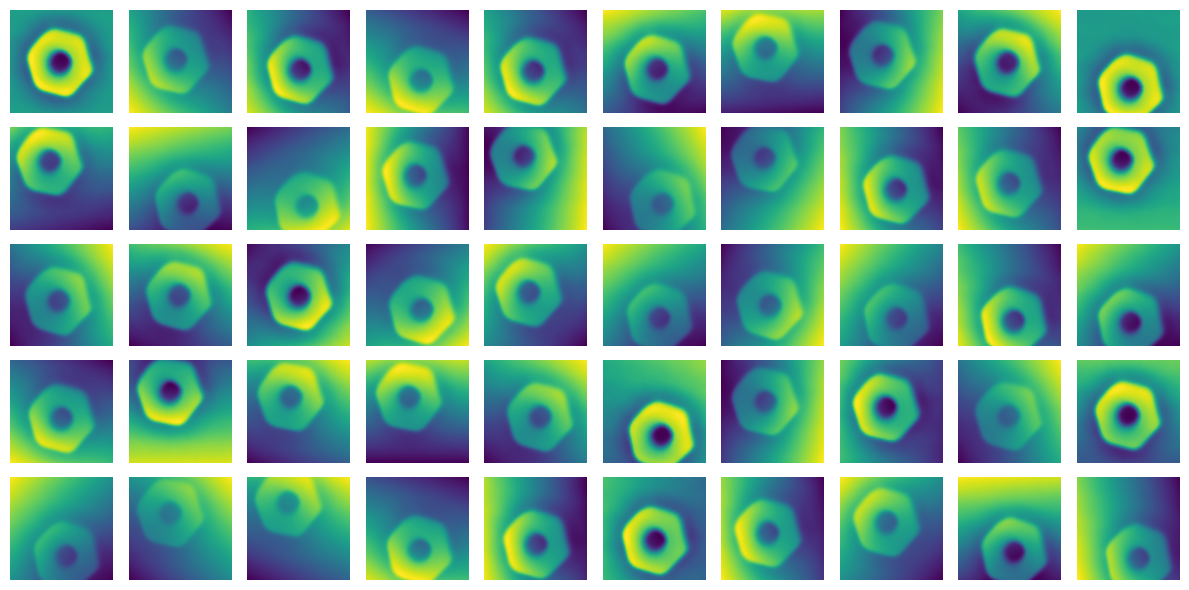

In [12]:
plot_transformed_crops(transformed_crops, num_cols=10, figsize=(12, 6))

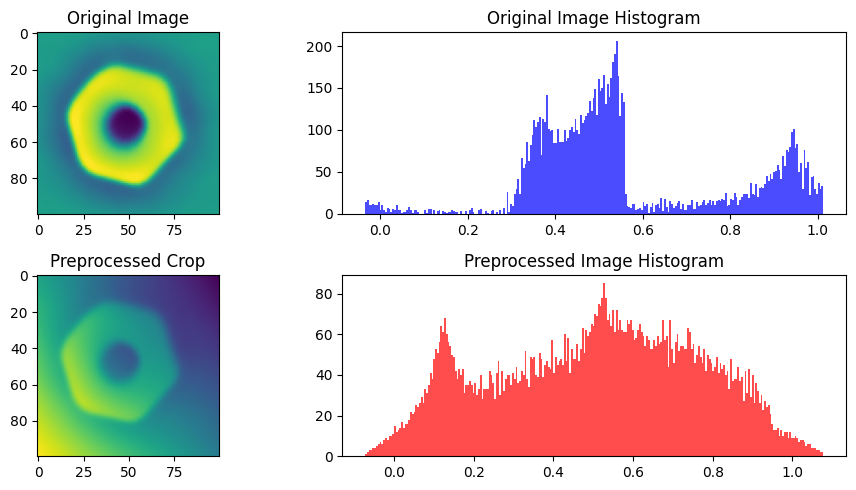

In [13]:
transformed_crops = normalize_images(transformed_crops)
visualize_histograms(preprocessed_crop, transformed_crops[1])

## 3. Aplicación de Transformaciones 2D
-----
En esta etapa, se aplican transformaciones 2D a los recortes transformados generados en la etapa anterior. Los pasos principales de esta etapa son:

1. **Definición de Transformaciones**: Se definen una secuencia de transformaciones 2D que se aplicarán a los recortes transformados. Estas transformaciones pueden incluir rotaciones, traslaciones, suavizado, multiplicación, entre otras.

2. **Generación del Conjunto de Entrenamiento**: Se selecciona aleatoriamente un recorte transformado y se aplica el pipeline de transformaciones para obtener el conjunto de entrenamiento. Esto implica aplicar todas las transformaciones definidas en el paso 1 a una imagen transformada específica.

La función `apply_2d_transformations` encapsula la lógica de aplicar las transformaciones. Recibe como entrada los recortes transformados y la secuencia de transformaciones, y devuelve el conjunto de entrenamiento resultante.



-------
### Generación de transformaciones 2D

In [14]:
#@title
def apply_2d_transformations(transformed_crops, transformations):
  pipeline = None
  for transformation in transformations:
    if pipeline is None:
      pipeline = transformation
    else:
      pipeline = pipeline >> transformation

  training_images = [np.expand_dims(image, axis=-1) for image in transformed_crops]
  train_set = dt.Value(lambda: np.array(random.choice(training_images))) >> pipeline

  return train_set

--------

In [15]:
wide = 20 # size of the training template
downsample = crop_size // wide

transformations = (
    dt.Affine(translate=lambda:np.random.uniform(-1.5, 1.5, 2), rotate=lambda: np.random.rand()*np.pi*2),
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)),
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
)

<Axes: >

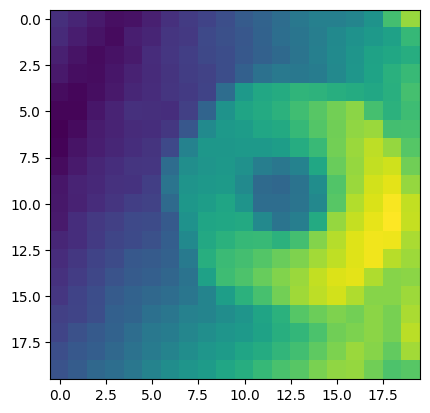

In [16]:
train_set = apply_2d_transformations(transformed_crops, transformations)
train_set.plot()

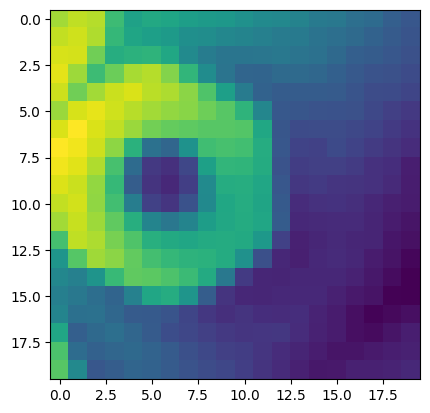

In [17]:
transformed_image = train_set.update()()
plt.imshow(transformed_image)

## 4. Entrenamiento del Modelo
-------------
En esta etapa, se entrena el modelo utilizando el conjunto de entrenamiento `train_set`. Los pasos principales de esta etapa son:

1. **Definición de Callbacks**: Se definen los callbacks necesarios para el entrenamiento del modelo. Esto incluye el checkpoint para guardar los pesos del modelo, early stopping para detener el entrenamiento si no hay mejoras significativas y un learning rate scheduler para ajustar la tasa de aprendizaje durante el entrenamiento.

2. **Entrenamiento del Modelo**: Se utiliza la función `fit` del modelo para entrenarlo con el conjunto de entrenamiento `train_set`. Se especifica el número de epochs, el tamaño de lote y se agregan los callbacks definidos en el paso anterior. El entrenamiento solo se realiza si la bandera `TRAIN_MODE` es verdadera.

3. **Visualización del Progreso del Entrenamiento**: Si `TRAIN_MODE` es verdadero, se muestra una gráfica con la evolución de la pérdida total y la pérdida de consistencia a lo largo de las epochs.


--------
### Configuración y entrenamiento del modelo

In [18]:
#@title
def train_model(model, train_set, weights_path, train_mode=True, epochs=40):

  callbacks = [ModelCheckpoint(filepath=weights_path,
                               save_weights_only=True,
                               monitor='total_loss',
                               mode='min',
                               save_best_only=True),

               EarlyStopping(monitor="total_loss",
                             patience=15,
                             verbose=1,
                             mode="auto",
                             restore_best_weights=True),

               LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))]

  if train_mode:
      history = model.fit(
          train_set,
          epochs=epochs,
          batch_size=8,
          callbacks=callbacks
      )

      fig, ax = plt.subplots(1, 2, figsize=(10, 4))

      # Plot total_loss
      ax[0].plot(history.history['total_loss'], label='Total Loss')
      ax[0].set_title('Total Loss over time')
      ax[0].set_xlabel('Epochs')
      ax[0].set_ylabel('Loss')
      ax[0].legend()

      # Plot consistency_loss
      ax[1].plot(history.history['consistency_loss'], label='Consistency Loss')
      ax[1].set_title('Consistency Loss over time')
      ax[1].set_xlabel('Epochs')
      ax[1].set_ylabel('Loss')
      ax[1].legend()

      plt.show()

  else:
      model.load_weights(weights_path)

  return history

---------

In [19]:
weights_path = '/content/drive/MyDrive/Investigacion/Model/checkpoints/3Ddebugging'
TRAIN_MODE = True

Generating 161 / 160 samples before starting training
Epoch 1/40
161/161 [==============================] - 20s 20ms/step - total_loss: 1.9434 - consistency_loss: 0.6099 - lr: 0.0010
Epoch 2/40
161/161 [==============================] - 7s 40ms/step - total_loss: 0.8627 - consistency_loss: 0.2411 - lr: 0.0010                           
Epoch 3/40
161/161 [==============================] - 6s 38ms/step - total_loss: 0.1492 - consistency_loss: 0.0256 - lr: 0.0010                          
Epoch 4/40
161/161 [==============================] - 7s 46ms/step - total_loss: 0.1023 - consistency_loss: 0.0156 - lr: 0.0010                          
Epoch 5/40
161/161 [==============================] - 6s 34ms/step - total_loss: 0.0729 - consistency_loss: 0.0102 - lr: 0.0010                           
Epoch 6/40
161/161 [==============================] - 8s 49ms/step - total_loss: 0.0684 - consistency_loss: 0.0082 - lr: 0.0010                          
Epoch 7/40
161/161 [=========================

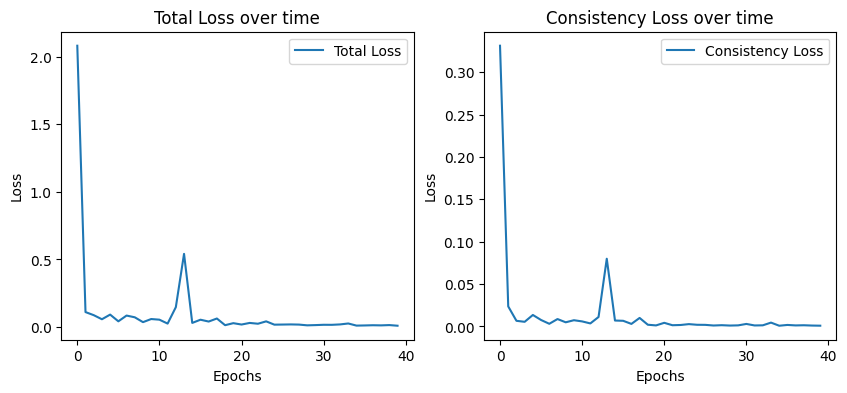

In [20]:
model = dt.models.LodeSTAR(input_shape=(None, None, 1))
history = train_model(model, train_set, weights_path, train_mode=TRAIN_MODE, epochs=40)

## 5. Detección multi-escala de objetos
------

En esta etapa, se lleva a cabo la detección de objetos en 3 versiones de imágenes escaladas. A continuación se detallan los pasos de esta etapa:


1. **Preprocesamiento de la imagen de prueba**: La función `preprocess_test_image` se encarga de realizar el preprocesamiento necesario en la imagen de prueba, para que esté en las mismas condiciones que la información con la que entrenó el modelo.

2. **Escalado de las imágenes de prueba**: Se utiliza la función `scale_test_images` para escalar las imágenes de prueba a diferentes tamaños.

3. **Detección de objetos**: La función `detect_objects` se encarga de realizar la detección de objetos en las imágenes escaladas utilizando el modelo y los parámetros especificados.

4. **Cálculo de los bounding boxes**: La función `calculate_bounding_boxes` se encarga de calcular los bounding boxes a partir de las detecciones obtenidas. Se tiene en cuenta el tamaño original del objeto a detectar y se ajusta proporcionalmente al tamaño de cada imagen escalada.

------
### Carga de datos de prueba

In [24]:
#@title
def load_test_data(file_path, key='Spz'):
    test_data = scipy.io.loadmat(file_path)
    test_image = test_data[key]
    return test_image

### Preprocesamiento de los datos de prueba

In [25]:
#@title
def preprocess_test_image(test_image):
    previous_test_image = np.copy(test_image)
    test_image = normalize_images(test_image)
    visualize_histograms(previous_test_image, test_image)

    return test_image, previous_test_image

### Escalamiento de imágenes

In [31]:
#@title
def scale_test_images(test_image, scales, plot=True):
    x_shape = test_image.shape[0]
    y_shape = test_image.shape[1]
    scaled_images = [cv2.resize(test_image, (int(y_shape // scale), int(x_shape // scale))) for scale in scales]

    if plot:
        fig, ax = plt.subplots(1, len(scaled_images), figsize=(10, 4))
        fig.tight_layout()
        fig.suptitle('Scaled 3D images', y=1)
        for index in range(len(scaled_images)):
            ax[index].imshow(scaled_images[index])

    return scaled_images

### Detección de objetos

In [35]:
#@title
def detect_objects(scaled_images, model, cutoff=0.9, downsample=downsample):
    alpha = 1 - cutoff
    mode = "quantile"
    all_detections = []

    for index in range(len(scaled_images)):
        test_set = scaled_images[index][np.newaxis, :, :, np.newaxis]
        test_set = test_set[:, ::downsample, ::downsample, :]
        detections = model.predict_and_detect(test_set, alpha=alpha, beta=1-alpha, cutoff=cutoff, mode=mode)[0]
        detections[:, 0] = detections[:, 0] * downsample
        detections[:, 1] = detections[:, 1] * downsample
        all_detections.append(detections)

    return all_detections

### Visualización de las detecciones

In [ ]:
#@title
def visualize_detections(scaled_images, all_detections):
    fig, ax = plt.subplots(1, len(scaled_images), figsize=(25, 5))
    fig.tight_layout()
    fig.suptitle('Detections', y=1)
    colors = 'rgb'

    for index in range(len(scaled_images)):
        ax[index].imshow(scaled_images[index])
        ax[index].scatter(all_detections[index][:, 1], all_detections[index][:, 0], color=colors[index])

    plt.show()

### Creación de bounding boxes

In [ ]:
#@title
def calculate_bounding_boxes(scaled_images, all_detections, crop_size):
    final_image = scaled_images[0]
    original_box_size = crop_size
    all_bboxes = []

    original_height, original_width = final_image.shape[:2]

    for index in range(len(all_detections)):
        current_height, current_width = scaled_images[index].shape[:2]

        box_size = original_box_size * (current_height / original_height)
        half_size = box_size / 2.0

        bboxes = np.zeros((len(all_detections[index]), 4))

        for i, point in enumerate(all_detections[index]):
            bboxes[i, 0] = point[0] - half_size
            bboxes[i, 1] = point[1] - half_size
            bboxes[i, 2] = point[0] + half_size
            bboxes[i, 3] = point[1] + half_size

        all_bboxes.append(bboxes)

    return all_bboxes

### Visualización de los bounding boxes

In [ ]:
#@title
def visualize_bounding_boxes(scaled_images, all_bboxes):
    fig, axs = plt.subplots(1, len(scaled_images), figsize=(25, 5))
    fig.tight_layout()
    fig.suptitle('Bounding boxes', y=1)
    colors = ['r', 'g', 'b']  # red, green, blue

    for i, image in enumerate(scaled_images):
        axs[i].imshow(image)

        for bbox in all_bboxes[i]:
            rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0],
                                 linewidth=2, edgecolor=colors[i], facecolor='none')
            axs[i].add_patch(rect)

    plt.show()

-------

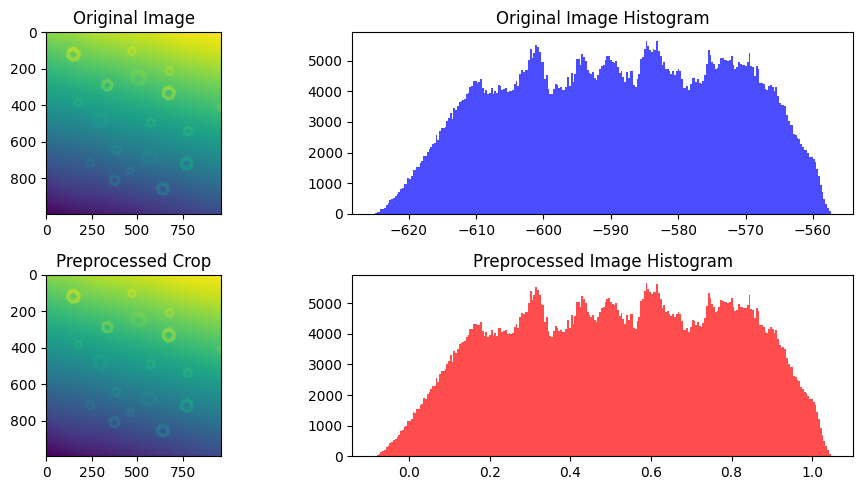

In [30]:
file_path = '/content/drive/MyDrive/Investigacion/Data/MATLAB/Reconstructions/with_surface_base/rec_r3d_smooth_pose_16.mat'
test_image = load_test_data(file_path, key='ZcM_r')
preprocessed_image, previous_image = preprocess_test_image(test_image)

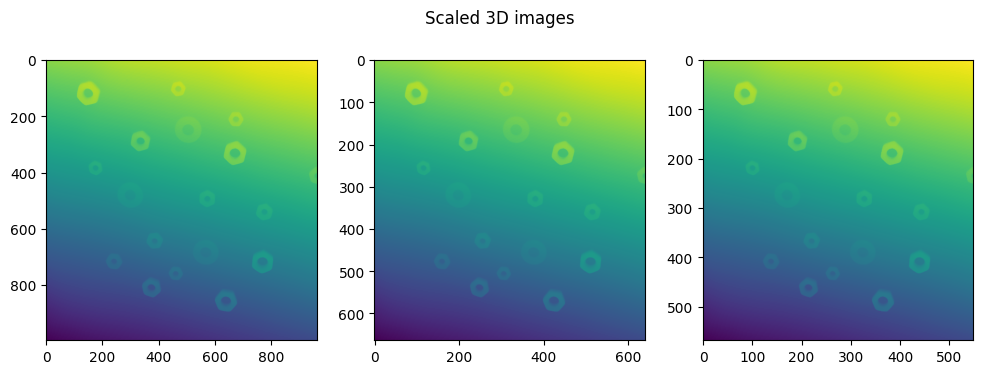

In [32]:
scales = [1, 1.5, 1.75]
scaled_images = scale_test_images(preprocessed_image, scales)

1/1 [==============================] - 0s 21ms/step


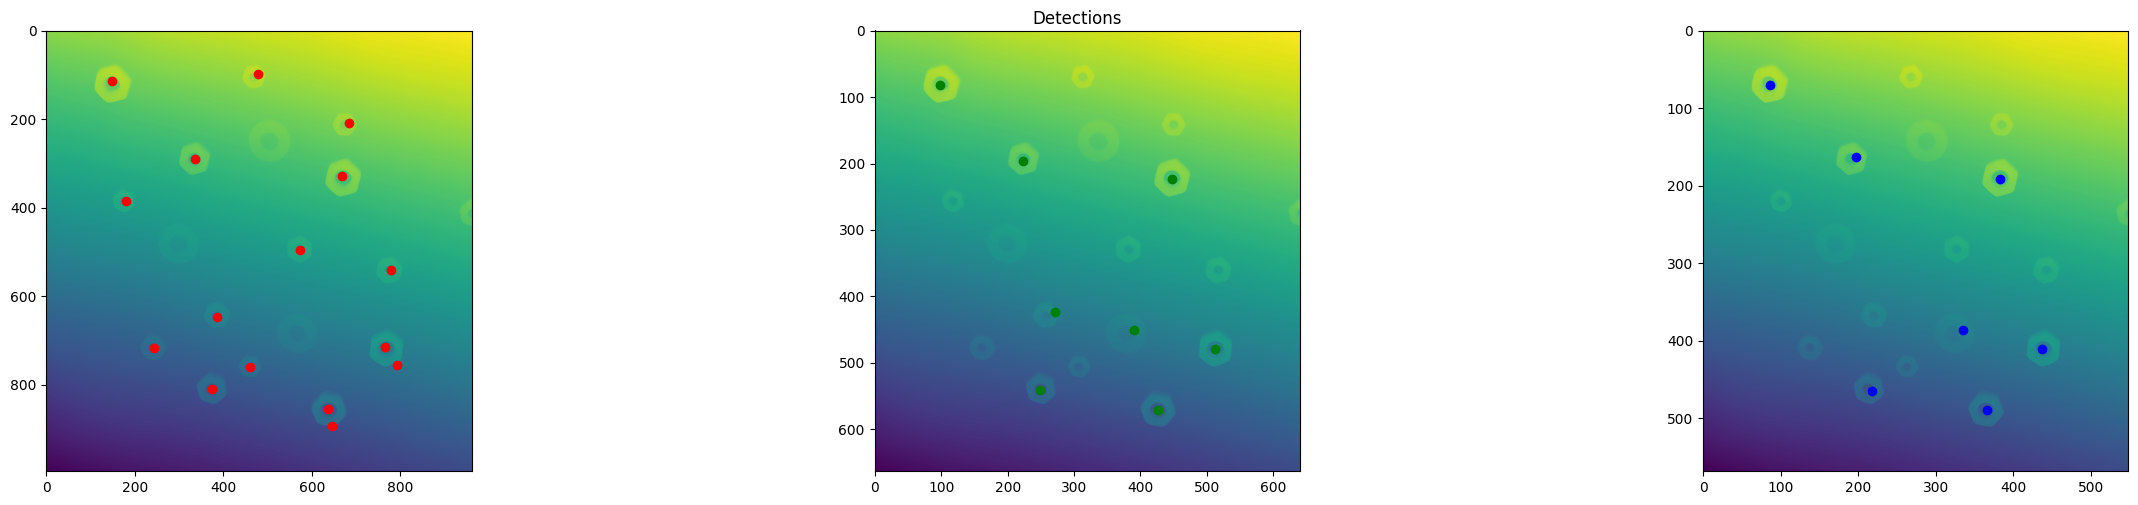

In [55]:
cutoff = 0.97
all_detections = detect_objects(scaled_images, model, cutoff=cutoff, downsample=downsample)
visualize_detections(scaled_images, all_detections)

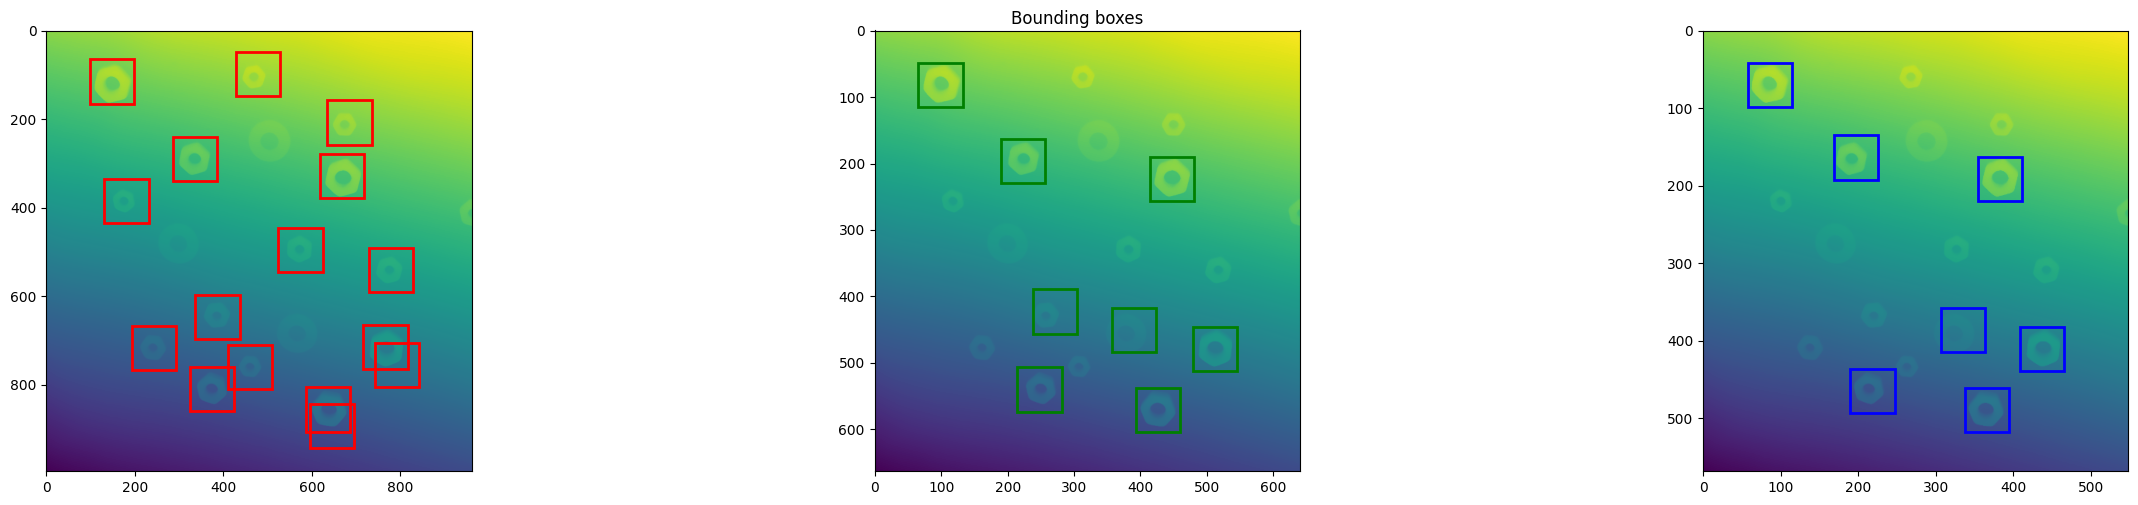

In [56]:
all_bboxes = calculate_bounding_boxes(scaled_images, all_detections, crop_size)
visualize_bounding_boxes(scaled_images, all_bboxes)

## 6. Supresión del No Máximo
-----

En esta etapa, se ajustan y visualizan los bounding boxes finales en la imagen original. Los pasos principales de esta etapa son:

1. **Ajuste de los Bounding Boxes**: Se ajustan las coordenadas de los bounding boxes mediante la función `adjust_bounding_boxes` para que estén en la misma escala que la imagen original.

2. **Aplicación de la Supresión del No Máximo**: Se aplica la función `apply_nms` para seleccionar los bounding boxes finales que representan las detecciones más relevantes.

-------
### Ajuste de bounding boxes

In [39]:
#@title
def adjust_bounding_boxes(all_bboxes, scales):
    all_bboxes_scaled = []
    for i in range(len(scales)):
        bboxes_scaled = all_bboxes[i] * scales[i]
        all_bboxes_scaled.append(bboxes_scaled)
    return all_bboxes_scaled

### Aplicación de Supresión del No Máximo

In [ ]:
#@title
def apply_nms(all_bboxes_scaled):
    all_bboxes_concat = np.concatenate(all_bboxes_scaled)
    confidences = [1] * len(all_bboxes_concat)
    indices = cv2.dnn.NMSBoxes(all_bboxes_concat.tolist(), confidences, score_threshold=0, nms_threshold=0.5)
    indices = [int(i) for i in indices]
    final_bboxes = [all_bboxes_concat[i] for i in indices]
    return final_bboxes

### Visualización de los bounding boxes finales

In [ ]:
#@title
def visualize_final_bboxes(final_image, final_bboxes):
    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.imshow(final_image)
    for bbox in final_bboxes:
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

---------

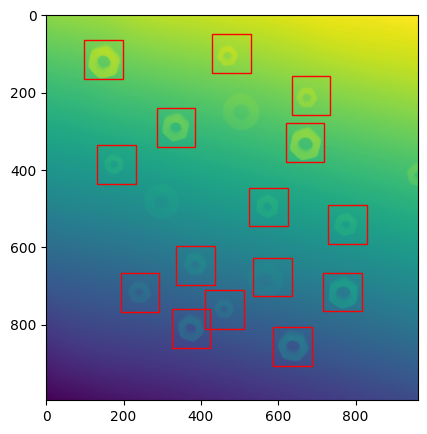

In [57]:
# Asegurémonos de que las bounding boxes están en la misma escala que la imagen original
all_bboxes_scaled = adjust_bounding_boxes(all_bboxes, scales)
# Aplicamos Non Maxima Suppression
final_bboxes = apply_nms(all_bboxes_scaled)
# Ploteamos los bounding boxes finales en la imagen original
visualize_final_bboxes(scaled_images[0], final_bboxes)